# **(Modelling and Evaluation Part-2)**

## Objectives

* Create a pipeline to make predictions for houses in the general area of Ames Iowa.
    - This is to satisfy part-2 of Business Requirement 2, 'any other houses in Ames, Iowa'

## Inputs

* outputs/datasets/collection/original_no_nan.csv 

## Outputs

* Train set (features and target)
* Test set (features and target)
* ML pipeline to predict house sale prices for houses in the general area of Ames Iowa.


---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/milestone-project-heritage-housing-issues/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/milestone-project-heritage-housing-issues'

## Load Data

In [4]:
import pandas as pd
import numpy as np

df = (pd.read_csv(f"outputs/datasets/collection/original_no_nan.csv")
    .drop(labels=['EnclosedPorch', 'WoodDeckSF'], axis=1)
    )
df.head(5)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854,3,No,706,GLQ,150,548,RFn,2003.0,...,8450,65.0,196.0,61,5,7,856,2003,2003,208500
1,1262,0,3,Gd,978,ALQ,284,460,RFn,1976.0,...,9600,80.0,0.0,0,8,6,1262,1976,1976,181500
2,920,866,3,Mn,486,GLQ,434,608,RFn,2001.0,...,11250,68.0,162.0,42,5,7,920,2001,2002,223500
3,961,0,0,No,216,ALQ,540,642,Unf,1998.0,...,9550,60.0,0.0,35,5,7,756,1915,1970,140000
4,1145,0,4,Av,655,GLQ,490,836,RFn,2000.0,...,14260,84.0,350.0,84,5,8,1145,2000,2000,250000


## Create the new pipeline

In [5]:
from sklearn.pipeline import Pipeline

# Feature Engineering
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine.transformation import LogTransformer, PowerTransformer

# Feat Scaling
from sklearn.preprocessing import StandardScaler

# Feat Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor

def PipelineOptimization(model):
    pipeline_base = Pipeline([

        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'])),

        ("log_10_transformer", LogTransformer(variables=['1stFlrSF', 'GrLivArea', 'LotArea', 'LotFrontage'], base='10')),

        ("power_transformer", PowerTransformer(variables=['BedroomAbvGr', 'BsmtUnfSF', 'GarageArea', 'TotalBsmtSF'], exp=0.5)),

        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="pearson", threshold=0.7, selection_method="variance")),

        ("feat_scaling", StandardScaler()),

        ("feat_selection",  SelectFromModel(model)),

        ("model", model),

    ])

    return pipeline_base


/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


---

### Load Custom Class for Hyperparameter Optimisation

In [6]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = PipelineOptimization(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches

### Split Train and Test Sets

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['SalePrice'], axis=1),
    df['SalePrice'],
    test_size=0.2,
    random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)

print(X_train.head(3))

* Train set: (1168, 21) (1168,) 
* Test set: (292, 21) (292,)
     1stFlrSF  2ndFlrSF  BedroomAbvGr BsmtExposure  BsmtFinSF1 BsmtFinType1  \
618      1828         0             0           Av          48         None   
870       894         0             2           No           0          Unf   
92        964         0             2           No         713          ALQ   

     BsmtUnfSF  GarageArea GarageFinish  GarageYrBlt  ...  KitchenQual  \
618       1774         774          Unf       2007.0  ...           Gd   
870        894         308         None       1962.0  ...           TA   
92         163         432          Unf       1921.0  ...           TA   

    LotArea  LotFrontage  MasVnrArea  OpenPorchSF  OverallCond  OverallQual  \
618   11694         90.0       452.0          108            5            9   
870    6600         60.0         0.0            0            5            5   
92    13360         80.0         0.0            0            7            5   

     To

- Assess the performance using default hyperparameters

In [8]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

In [9]:
print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1168, 21) (1168,) 
* Test set: (292, 21) (292,)


In [10]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.In

In [11]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
0,LinearRegression,0.735427,0.809722,0.854261,0.044392
3,ExtraTreesRegressor,0.697044,0.804563,0.860545,0.057167
5,GradientBoostingRegressor,0.635793,0.768876,0.831192,0.070259
4,AdaBoostRegressor,0.648687,0.754101,0.813391,0.05567
2,RandomForestRegressor,0.630557,0.71583,0.817727,0.071702
6,XGBRegressor,0.516448,0.650623,0.751455,0.087641
1,DecisionTreeRegressor,0.488006,0.571741,0.667303,0.071561


**I am selecting the second best regressor model in this list to refine the hyperparameters and the quantity of features needed for widget inputs on the dashboard**

- The Linear Regressor only managed 0.7 on the Test set with 9 important features.
    - This notebook will attempt to get a better performing model with less features needed to make the predictions.

In [12]:
best_model = grid_search_summary.iloc[1,0]
best_model

'ExtraTreesRegressor'

- I have used mostly the values from the Gradient Boosting Regressor algorithim from book 5 but added min_impurity_decrease also here.

- min_impurity_decrease will allow the algorithm to choose values for how big a node can be before it is split into smaller nodes.

- Modifying this parameter will help the model to avoid overfitting.

In [13]:
models_search = {
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
}

params_search = {
    "ExtraTreesRegressor":{'model__n_estimators': [100,50,150,200],
                            'model__max_depth': [None,2,3,5,10,15],
                            'model__min_samples_split': [2,100],
                            'model__min_samples_leaf': [1,50],
                            'model__max_leaf_nodes': [2,50],
                            'model__min_impurity_decrease':[0.1,0.2,0.3],
                            }
  }

In [14]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa

In [15]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__max_leaf_nodes,model__min_impurity_decrease,model__min_samples_leaf,model__min_samples_split,model__n_estimators
529,ExtraTreesRegressor,0.696132,0.807021,0.855991,0.057381,15,50,0.1,1,2,50
49,ExtraTreesRegressor,0.696132,0.807021,0.855991,0.057381,None,50,0.1,1,2,50
65,ExtraTreesRegressor,0.696132,0.807021,0.855991,0.057381,None,50,0.2,1,2,50
81,ExtraTreesRegressor,0.696132,0.807021,0.855991,0.057381,None,50,0.3,1,2,50
561,ExtraTreesRegressor,0.696132,0.807021,0.855991,0.057381,15,50,0.3,1,2,50
...,...,...,...,...,...,...,...,...,...,...,...
493,ExtraTreesRegressor,0.420907,0.461923,0.50131,0.029852,15,2,0.1,50,100,50
29,ExtraTreesRegressor,0.420907,0.461923,0.50131,0.029852,None,2,0.2,50,100,50
201,ExtraTreesRegressor,0.420907,0.461923,0.50131,0.029852,3,2,0.1,50,2,50
25,ExtraTreesRegressor,0.420907,0.461923,0.50131,0.029852,None,2,0.2,50,2,50


- ExtraTreesRegressor seems to be performing well at this point.

In [16]:
best_model = grid_search_summary.iloc[0,0]
best_model

'ExtraTreesRegressor'

In [17]:
best_parameters = grid_search_pipelines[best_model].best_params_

In [18]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['BsmtExposure', 'BsmtFinType1',
                                           'GarageFinish', 'KitchenQual'])),
                ('log_10_transformer',
                 LogTransformer(base='10',
                                variables=['1stFlrSF', 'GrLivArea', 'LotArea',
                                           'LotFrontage'])),
                ('power_transformer',
                 PowerTransformer(variables=['BedroomAbvGr', 'BsmtUnfSF',
                                             'Gara...
                                                     'KitchenQual', 'LotArea',
                                                     'LotFrontage',
                                                     'MasVnrArea',
                                                     'OpenPorchSF',
                                                     'OverallCond',
   

### Assesing Feature Importance

* These are the 5 most important features in descending order. The model was trained on them: 
['1stFlrSF', 'GarageArea', 'GrLivArea', 'OverallQual', 'YearBuilt']


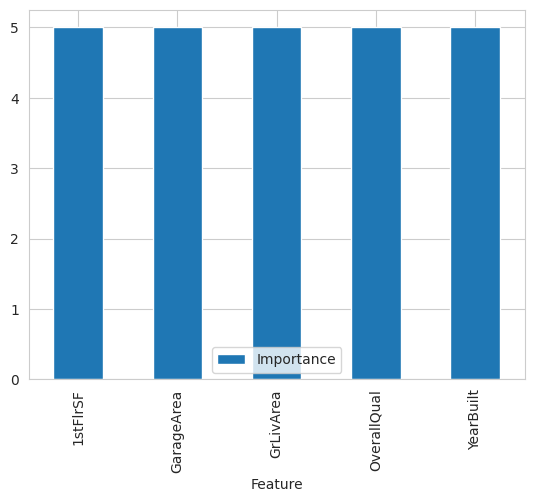

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

data_cleaning_feat_eng_steps = 4
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support(
)].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()],
    'Importance': best_regressor_pipeline['model'].n_features_in_})
    .sort_values(by='Importance', ascending=False)
)

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

### Load the evaluation functions.

In [20]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)


def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(
        mean_squared_error(y, prediction)).round(3))
    print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    plt.show()

Model Evaluation 

* Train Set
R2 Score: 0.905
Mean Absolute Error: 17770.496
Mean Squared Error: 585610338.493
Root Mean Squared Error: 24199.387


* Test Set
R2 Score: 0.867
Mean Absolute Error: 19496.108
Mean Squared Error: 915485028.774
Root Mean Squared Error: 30256.983




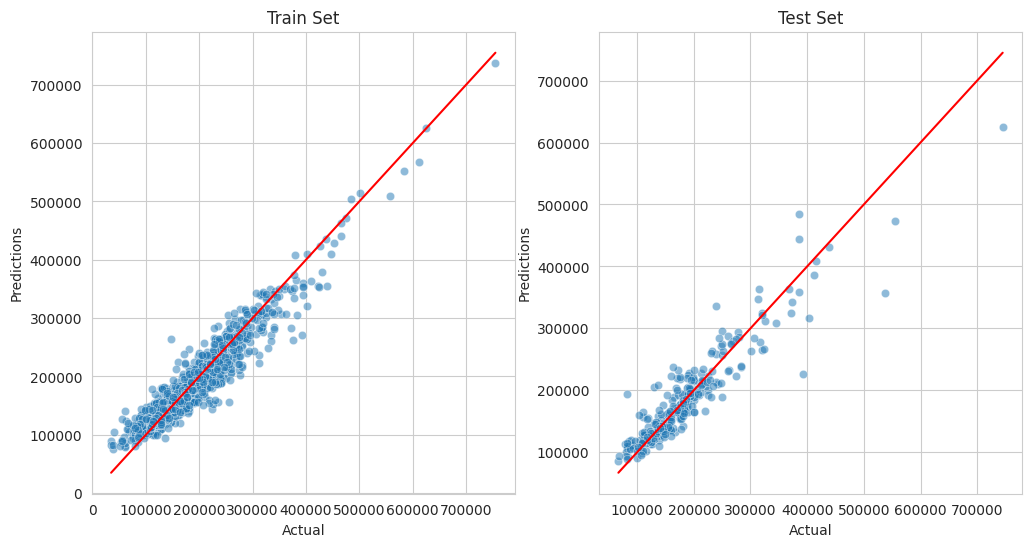

In [21]:
regression_performance(X_train, y_train, X_test, y_test,best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test,
                            best_regressor_pipeline)

- This model is performing quite well. The R2 score is .90 for Train and .86 for Test. The MAE error and RMSE both read well without too much variation in their values and the plots look better than the Linear regression model from the previous book.

#### RE-Write the pipeline using the most important features

In [22]:
def PipelineOptimization(model):
    pipeline_base = Pipeline([

        ("log_10_transformer", LogTransformer(variables=['1stFlrSF', 'GrLivArea'], base='10')),

        ("power_transformer", PowerTransformer(variables=['GarageArea'], exp=0.5)),

        ("feat_scaling", StandardScaler()),

        ("model", model),

    ])

    return pipeline_base

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['SalePrice'], axis=1),
    df['SalePrice'],
    test_size=0.2,
    random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)


* Train set: (1168, 21) (1168,) 
* Test set: (292, 21) (292,)


### Filter the data for the best features only

In [24]:
X_train = X_train.filter(best_features)
X_test = X_test.filter(best_features)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
X_train.head(3)

(1168, 5) (1168,) (292, 5) (292,)


,1stFlrSF,GarageArea,GrLivArea,OverallQual,YearBuilt
618,1828,774,1828,9,2007
870,894,308,894,5,1962
92,964,432,964,5,1921


In [25]:
models_search

{'ExtraTreesRegressor': ExtraTreesRegressor(random_state=0)}

In [26]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__max_depth': None,
 'model__max_leaf_nodes': 50,
 'model__min_impurity_decrease': 0.1,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 50}

In [27]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


In [28]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__max_leaf_nodes,model__min_impurity_decrease,model__min_samples_leaf,model__min_samples_split,model__n_estimators
50,ExtraTreesRegressor,0.698795,0.810571,0.859183,0.057394,None,50,0.1,1,2,150
546,ExtraTreesRegressor,0.698795,0.810571,0.859183,0.057394,15,50,0.2,1,2,150
82,ExtraTreesRegressor,0.698795,0.810571,0.859183,0.057394,None,50,0.3,1,2,150
66,ExtraTreesRegressor,0.698795,0.810571,0.859183,0.057394,None,50,0.2,1,2,150
530,ExtraTreesRegressor,0.698795,0.810571,0.859183,0.057394,15,50,0.1,1,2,150
...,...,...,...,...,...,...,...,...,...,...,...
493,ExtraTreesRegressor,0.411107,0.453535,0.486757,0.026477,15,2,0.1,50,100,50
29,ExtraTreesRegressor,0.411107,0.453535,0.486757,0.026477,None,2,0.2,50,100,50
201,ExtraTreesRegressor,0.411107,0.453535,0.486757,0.026477,3,2,0.1,50,2,50
25,ExtraTreesRegressor,0.411107,0.453535,0.486757,0.026477,None,2,0.2,50,2,50


In [29]:
best_model = grid_search_summary.iloc[0, 0]
pipeline_general_ames_iowa = grid_search_pipelines[best_model].best_estimator_
pipeline_general_ames_iowa


Pipeline(steps=[('log_10_transformer',
                 LogTransformer(base='10',
                                variables=['1stFlrSF', 'GrLivArea'])),
                ('power_transformer',
                 PowerTransformer(variables=['GarageArea'])),
                ('feat_scaling', StandardScaler()),
                ('model',
                 ExtraTreesRegressor(max_leaf_nodes=50,
                                     min_impurity_decrease=0.1,
                                     n_estimators=150, random_state=0))])

In [30]:
best_features

['1stFlrSF', 'GarageArea', 'GrLivArea', 'OverallQual', 'YearBuilt']

Model Evaluation 

* Train Set
R2 Score: 0.904
Mean Absolute Error: 17859.126
Mean Squared Error: 589356675.43
Root Mean Squared Error: 24276.669


* Test Set
R2 Score: 0.871
Mean Absolute Error: 19448.026
Mean Squared Error: 890640245.533
Root Mean Squared Error: 29843.596




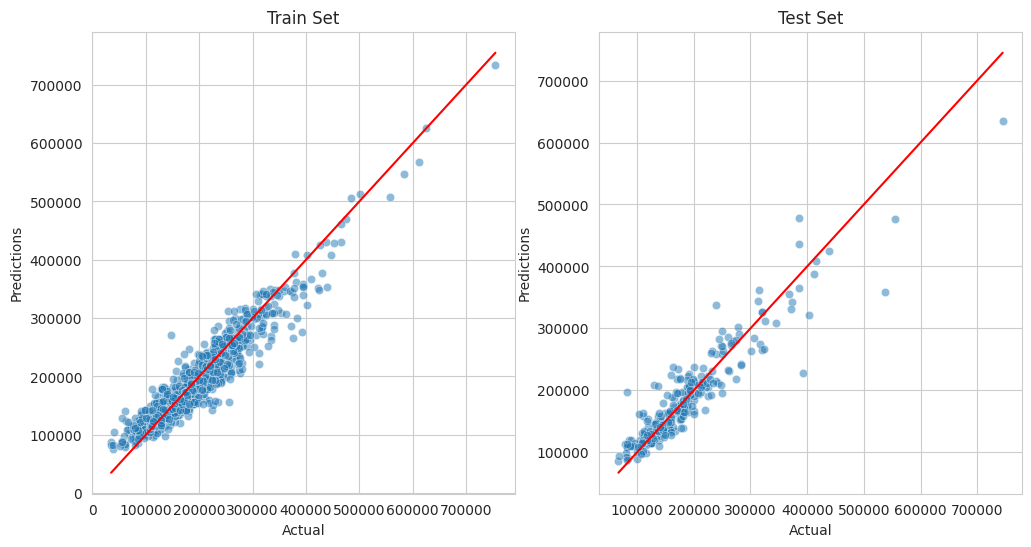

In [33]:
regression_performance(X_train, y_train, X_test, y_test,pipeline_general_ames_iowa)
regression_evaluation_plots(X_train, y_train, X_test, y_test,
                            pipeline_general_ames_iowa)

- The refined pipeline with fewer features is performing as expected.

In [36]:
deploy_pipeline = pipeline_general_ames_iowa

deploy_pipeline 

Pipeline(steps=[('log_10_transformer',
                 LogTransformer(base='10',
                                variables=['1stFlrSF', 'GrLivArea'])),
                ('power_transformer',
                 PowerTransformer(variables=['GarageArea'])),
                ('feat_scaling', StandardScaler()),
                ('model',
                 ExtraTreesRegressor(max_leaf_nodes=50,
                                     min_impurity_decrease=0.1,
                                     n_estimators=150, random_state=0))])

# Push files to Repo

In [34]:
import joblib
import os

version = 'v3'
file_path = f'outputs/ml_pipeline/predict_sale_price/{version}'

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)

[Errno 17] File exists: 'outputs/ml_pipeline/predict_sale_price/v3'


In [37]:
joblib.dump(value=deploy_pipeline, filename=f"{file_path}/deploy_extratrees_pipeline.pkl")

['outputs/ml_pipeline/predict_sale_price/v3/deploy_extratrees_pipeline.pkl']

In [38]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [39]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

In [40]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [41]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

---